# Policy Gradient

In this tutorial, we will present the idea of policy gradient, and show how to use gluon to implement a policy gradient agent.
To make things easy, we only solve a simple environment CartPole in this jupyter notebook (4 mins on MacBook Pro). But the code for more complex environment like Atari game Pong is also provided. You can try it if you are interested.


## Preliminaries

We use the popular toolkit OpenAI Gym as our environment. Use the following commonds to install OpenAI gym.
```bash
pip install gym
pip install gym[atari]
```
Full documentation for the gym can be found on at [this website](https://gym.openai.com/).

## Policy Gradient Theorem

This section briefly introduces the theorem behind the update rule of policy gradient. We want to optimize our policy so that to maximize long-term reward.

Consider a simple one-step MDP (Markov Decission Precess). It starts in state $s \sim d(s)$, and termiates after one time-step with reward $r = \mathcal{R}_{s,a}$. The expected reward is 

$$J(\theta) = \mathbb{E}_{\pi_{\theta}}[r]
            = \sum_{s \in \mathcal{S}}{d(s) \sum_{a \in \mathcal{A}}{\pi_\theta(s,a)\mathcal{R}_{s,a}}}$$

Then we can use likelihood ratios to compute the policy gradient.

$$\nabla_\theta J(\theta) = \sum_{s \in \mathcal{S}}{d(s) \sum_{a \in \mathcal{A}}{\pi_\theta(s,a) \nabla_\theta log(\pi_\theta(s,a))\mathcal{R}_{s,a}}} = \mathbb{E}_{\pi_{\theta}}[\nabla_\theta log(\pi_\theta(s,a)) r]$$

By generalising the likelihood ratio approach to multi-step MDPs and replace instataneous reward $r$ by long-term value $Q^{\pi_\theta}(s,a)$, we can get policy gradient theorem.

**Theorem** For any differentiable policy  $\pi_\theta(s,a)$, for any of the policy objective functions $J = J_1$, $J_{average\_reward}$ or $\frac{1}{1-\gamma}J_{average\_value}$ , the policy gradient is 
$$\nabla_\theta J(\theta) = \mathbb{E}_{\pi_{\theta}}[\nabla_\theta log(\pi_\theta(s,a)) Q^{\pi_\theta}(s,a)]$$

In practice, we just update our parameters according to this formula.




## Implementation
Here we use an algorithm called REINFORCE, which is a Monte-Carlo version of policy gradient. The idea is to sample some transitions and update parameters by policy gradient. We can use returned reward as an unbiased estimation of $Q^{\pi_\theta}(s,a)$ in the theorem above.

First, we define a class to store the transitions (observation, action, reward) in a whole episode. They are the training data for policy network.

In [1]:
import gym
import numpy as np
import mxnet as mx
from mxnet import nd, autograd, gluon

class Episode:
    def __init__(self):
        self.observation = []
        self.action = []
        self.reward = []

    def append(self, s, a, r):
        self.observation.append(s)
        self.action.append(a)
        self.reward.append(r)

Next, we can define the agent. It uses a multilayer perceptron with 200 hidden units as its policy network.
When inferring action, we do a softmax over the output to get the policy $\pi$ and sample an action from $\pi$.

As for trainning, we need do some pre-precess to the reward. An immediate reward is not only  resulted by a single action, but also by actions taken several steps before, so a discounted factor $\lambda$ is introduced to assign discounted reward to previous actions. Besides, in order to reduce variance, it's a common trick to substract a baseline function from the reward. Here we only use a simple empirical mean as baseline, more advaned methods may also train a network to predict this baseline. Finally, we utilize the autograd in gluon to compute gradient. You can see there is a minus sign in the loss function. The reason is that the trainer minimizes loss by default, but we want to maximize the cumulative reward. Thus a minus sign is necessary.

In [8]:
class Agent:
    def __init__(self, action_space, ctx):
        self.action_number = action_space.n

        # define a MLP
        net = gluon.nn.Sequential()
        with net.name_scope():
            net.add(gluon.nn.Flatten())
            net.add(gluon.nn.Dense(200, activation='relu'))
            net.add(gluon.nn.Dense(self.action_number))

        net.collect_params().initialize(mx.init.Xavier(magnitude=0.5), ctx=ctx)
        self.trainer = gluon.Trainer(net.collect_params(), 'adam',
                                    {'learning_rate': 1e-3})

        self.net = net
        self.ctx = ctx

    def act(self, observation):
        # transform a single observation to a batch, necessary for shape inference
        observation = [observation]
        obs = mx.nd.array(observation, ctx=self.ctx)

        policy = self.net(obs)[0] # get the first item of return batch
        policy = mx.nd.softmax(policy).asnumpy()

        return np.random.choice(np.arange(self.action_number), p=policy)

    def train(self, episode):
        s, a, r = episode.observation, episode.action, episode.reward

        # discount reward
        discount = 0.99
        keep = 0
        for i in reversed(range(len(r))):
            keep = keep * discount + r[i]
            r[i] = keep

        s = mx.nd.array(s, ctx=self.ctx)
        a = mx.nd.array(a, ctx=self.ctx).one_hot(self.action_number)
        r = mx.nd.array(r, ctx=self.ctx).reshape((len(r), 1))

        # substract baseline
        r -= mx.nd.mean(r)

        # forward
        with autograd.record():
            output = self.net(s)
            policy = mx.nd.softmax(output)
            policy = mx.nd.clip(policy, 1e-6, 1 - 1e-6) # clip for log
            log_policy = mx.nd.log(policy)
            loss = -mx.nd.sum(r * log_policy * a)

        loss.backward()
        self.trainer.step(len(s))

The following is the function to collect transitions by simulating an episode. Since the policy gradient is an on-policy method, we should collect transitions by following the current policy.

In [9]:
def run_episode(env, agent, render):
    episode = Episode()

    observation = env.reset()
    done = False
    while not done:
        action = agent.act(observation)
        next_observation, reward, done, _ = env.step(action)
        episode.append(observation, action, reward)

        observation = next_observation
        if render:
            env.render()

    return episode

Once we get every part done, it is time to begin the training loop.  (4 mins on MacBook Pro)

In [10]:
# init environment and agent
env = gym.make("CartPole-v1")
agent = Agent(env.action_space, mx.cpu())

print("observation space : {}".format(env.observation_space))
print("action space : {}".format(env.action_space))

n_episodes = 1000
mean_reward = 0
reward_log = []

for i in range(n_episodes):
    # collect transitions
    episode = run_episode(env, agent, render=False)
    reward = sum(episode.reward)

    # save moving average of episode reward for plotting
    if i == 0:
        mean_reward = reward
    else:
        mean_reward = 0.99 * mean_reward + 0.01 * reward
    reward_log.append(mean_reward)

    # train the agent
    agent.train(episode)

    if i % 50 == 0:
        print("episode: %d  reward: %.2f  mean reward: %.2f" %
                (i, reward, mean_reward))
    
print("done")

observation space : Box(4,)
action space : Discrete(2)
episode: 0  reward: 15.00  mean reward: 15.00
episode: 50  reward: 50.00  mean reward: 19.05
episode: 100  reward: 16.00  mean reward: 23.03
episode: 150  reward: 75.00  mean reward: 30.98
episode: 200  reward: 132.00  mean reward: 51.49
episode: 250  reward: 500.00  mean reward: 131.17
episode: 300  reward: 500.00  mean reward: 253.50
episode: 350  reward: 500.00  mean reward: 333.18
episode: 400  reward: 348.00  mean reward: 385.56
episode: 450  reward: 500.00  mean reward: 425.69
episode: 500  reward: 500.00  mean reward: 440.79
episode: 550  reward: 483.00  mean reward: 455.47
episode: 600  reward: 500.00  mean reward: 454.21
episode: 650  reward: 500.00  mean reward: 471.28
episode: 700  reward: 500.00  mean reward: 474.28
episode: 750  reward: 500.00  mean reward: 482.53
episode: 800  reward: 500.00  mean reward: 488.84
episode: 850  reward: 500.00  mean reward: 489.73
episode: 900  reward: 500.00  mean reward: 493.79
episode

## Plot Learning Curve
The reward curve can be plotted as follows

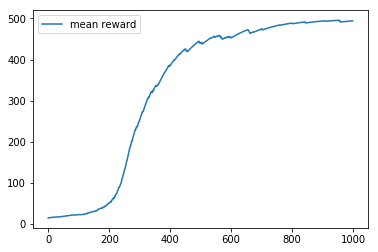

In [11]:
# plot reward
import matplotlib.pyplot as plt
plt.plot(reward_log)
plt.legend(["mean reward"])
plt.show()

## More Complex Environment
In order to solve more complex environment like Atari game Pong. There are just several modifications you should do. The network part can even be the same, you only need to pre-process the input image of Atari games. The following is an example.
But this brute force policy gradient will cost a lot of training time, you'd better try other advanced methods like A3C to save you time and get better performance.

In fact, this tutorial reference some parts of [this blog post](http://karpathy.github.io/2016/05/31/rl/) by Andrej Karpathy. Our network structure are the same. So I also recommond you to read throught it and see what will happen when solving Pong.

In [7]:
class AtariPreprocessedEnv:
    """ A warper for atari game environment.
    To use this warpper, replace 'env = gym.make("CartPole-v1")' with 
    'env = AtariPreprocessedEnv()' and paste the definition of this warpper
    before that statement (class should be defined before use)
    """
    def __init__(self, name="PongDeterministic-v0"):
        self.env = gym.make(name)
        self.action_space = self.env.action_space
        self.observation_space = (80*80,)

        self.pre_image = None

    def _preprocess(self, img):
        """ transform a 210x160x3 uint8 image to a 6400x1 float vector 
        Crop, down-sample, erase background and set foreground to 1
        ref: https://gist.github.com/karpathy/a4166c7fe253700972fcbc77e4ea32c5
        """
        img = img[35:195]
        img = img[::2, ::2, 0]
        img[img == 144] = 0
        img[img == 109] = 0
        img[img != 0] = 1
        curr = img.astype(np.float).ravel()
        # Subtract the last preprocessed image.
        diff = (curr - self.pre_image if self.pre_image is not None
                else np.zeros_like(curr))
        self.pre_image = curr
        return diff

    def reset(self):
        self.pre_image = None
        return self._preprocess(self.env.reset())

    def step(self, action):
        o, r, d, i = self.env.step(action)
        return self._preprocess(o), r, d, i

    def render(self):
        self.env.render()

For whinges or inquiries, [open an issue on GitHub.](https://github.com/zackchase/mxnet-the-straight-dope)